In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values

CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

# Keys are different values for the renormalization scale parameter X
pQCD_values = {
    1: [2.6, 6.14, 2334/1000],
    2: [2.6, 6.47, 3823/1000],
    4: [2.6, 6.87, 4284/1000]
}

In [3]:
class pQCD_constraints:

    def __init__(self, muL, nL, pL, muH, nH, pH):
        """
        Initialize the pQCD_constraints class. Functions taken from Komoltsev 
        & Kurkela 2022, arXiv:2111.05350.
        
        Parameters
        ----------
        muL, nL, pL : float
            Predicted values of the baryon chemical potential [GeV], baryon 
            number density [1/fm^3], and pressure [GeV/fm^3] at low density.
        
        muH, nH, pH : float
            Predicted values of the baryon chemical potential [GeV], baryon 
            number density [1/fm^3], and pressure [GeV/fm^3] at high density.
        """
        self.muL = muL
        self.nL = nL
        self.pL = pL
        self.muH = muH
        self.nH = nH
        self.pH = pH

        self.Deltap = pH - pL
        self.muc = np.sqrt(
            (muL*muH*(muH*nH - muL*nL - 2*self.Deltap))/(muL*nH - muH*nL)
            )
        
        self.nmax = np.vectorize(self.nmax_scalar)
        self.nmin = np.vectorize(self.nmin_scalar)

        self.pmax = np.vectorize(self.pmax_scalar)

    def nmin_scalar(self, mu):
        """
        Returns the minimum allowed value of the baryon number density at a
        given baryon chemical potential.
        """
        if self.muL <= mu <= self.muc:
            return self.nL*mu/self.muL
        
        elif self.muc < mu <= self.muH:
            numerator = mu**3*self.nH - mu*self.muH*(self.muH*self.nH - 2*self.Deltap)
            denominator = (mu**2 - self.muL**2)*self.muH
            return numerator/denominator
        
        else:
            raise ValueError('mu is outside the range [muL, muH]')
        
    def nmax_scalar(self, mu):
        """
        Returns the maximum allowed value of the baryon number density at a 
        given baryon chemical potential.
        """
        if self.muL <= mu < self.muc:
            numerator = mu**3*self.nL - mu*self.muL*(self.muL*self.nL + 2*self.Deltap)
            denominator = (mu**2 - self.muH**2)*self.muL
            return numerator/denominator
        
        elif self.muc <= mu <= self.muH:
            return self.nH*mu/self.muH
        
        else:
            raise ValueError('mu is outside the range [muL, muH]')
        
    def nc(self, mu):
        """
        The special EOS for which the speed of sound is equal to the speed of
        light throughout the whole region.
        """
        return (self.nmax(self.muL)*mu)/self.muL

    def pmin(self, mu):
        """
        Returns the minimum allowed value of the pressure at a given baryon
        chemical potential.
        """
        return self.pL + ((mu**2 - self.muL**2)/(2*mu))*self.nmin(mu)
    
    def pmax_scalar(self, mu, n):
        """
        Returns the maximum allowed value of the pressure at a given baryon
        chemical potential and baryon number density.
        """
        if n < self.nc(mu):
            return self.pL + ((mu**2 - self.muL**2)/(2*mu))*n
        
        else:
            return self.pH - ((self.muH**2 - mu**2)/(2*mu))*n
        
    def epsilon_min(self, mu):
        """
        Returns the minimum allowed value of the energy density at a given 
        baryon chemical potential.
        """
        return -self.pmax(mu, self.nmin(mu)) + mu*self.nmin(mu)
    
    def epsilon_max(self, mu):
        """
        Returns the maximum allowed value of the energy density at a given 
        baryon chemical potential.
        """
        return -self.pmin(mu) + mu*self.nmax(mu)

In [4]:
muL, nL, pL = CET_values['stiff']
muH, nH, pH = pQCD_values[2]

epsilonL = -pL + muL*nL
epsilonH = -pH + muH*nH

mu_array = np.linspace(muL, muH, 1000)

constraints = pQCD_constraints(muL, nL, pL, muH, nH, pH)

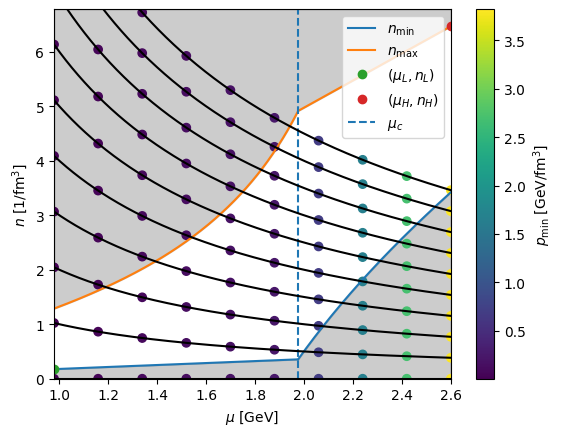

In [5]:
fig, ax = plt.subplots()

ax.plot(mu_array, constraints.nmin(mu_array), label=r'$n_\mathrm{min}$')
ax.plot(mu_array, constraints.nmax(mu_array), label=r'$n_\mathrm{max}$')

ax.plot(muL, nL, 'o', label=r'$(\mu_L, n_L)$')
ax.plot(muH, nH, 'o', label=r'$(\mu_H, n_H)$')

ax.axvline(constraints.muc, ls='--', label=r'$\mu_c$')

ylim = [0, ax.get_ylim()[1]]

ax.fill_between(mu_array, constraints.nmax(mu_array), ylim[1], color='k', alpha=0.2)
ax.fill_between(mu_array, constraints.nmin(mu_array), ylim[0], color='k', alpha=0.2)

for h in range(10):
    ax.plot(mu_array, h/mu_array, c='k')

reduced_mu_array = np.linspace(muL, muH, 10)
for h in range(10):
    im = ax.scatter(reduced_mu_array, h/reduced_mu_array, c=constraints.pmin(reduced_mu_array), cmap='viridis')
cbar = fig.colorbar(im, ax=ax)

cbar.set_label(r'$p_\mathrm{min}$ [GeV/fm$^3$]')

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend()

ax.set_xlim(muL, muH)
_ = ax.set_ylim(ylim)

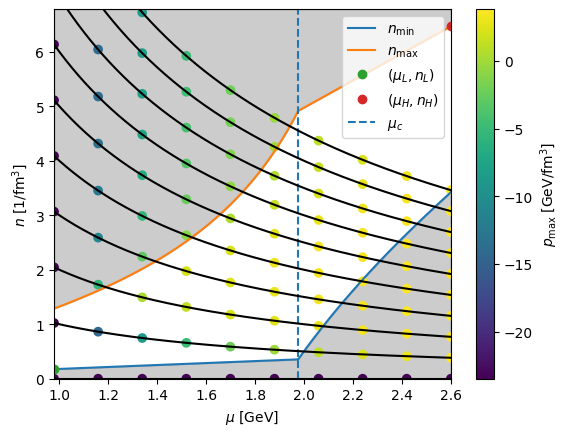

In [6]:
fig, ax = plt.subplots()

ax.plot(mu_array, constraints.nmin(mu_array), label=r'$n_\mathrm{min}$')
ax.plot(mu_array, constraints.nmax(mu_array), label=r'$n_\mathrm{max}$')

ax.plot(muL, nL, 'o', label=r'$(\mu_L, n_L)$')
ax.plot(muH, nH, 'o', label=r'$(\mu_H, n_H)$')

ax.axvline(constraints.muc, ls='--', label=r'$\mu_c$')

ylim = [0, ax.get_ylim()[1]]

ax.fill_between(mu_array, constraints.nmax(mu_array), ylim[1], color='k', alpha=0.2)
ax.fill_between(mu_array, constraints.nmin(mu_array), ylim[0], color='k', alpha=0.2)

for h in range(10):
    ax.plot(mu_array, h/mu_array, c='k')

reduced_mu_array = np.linspace(muL, muH, 10)
for h in range(10):
    im = ax.scatter(reduced_mu_array, h/reduced_mu_array, c=constraints.pmax(reduced_mu_array, h/reduced_mu_array), cmap='viridis')
cbar = fig.colorbar(im, ax=ax)

cbar.set_label(r'$p_\mathrm{max}$ [GeV/fm$^3$]')

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend()

ax.set_xlim(muL, muH)
_ = ax.set_ylim(ylim)

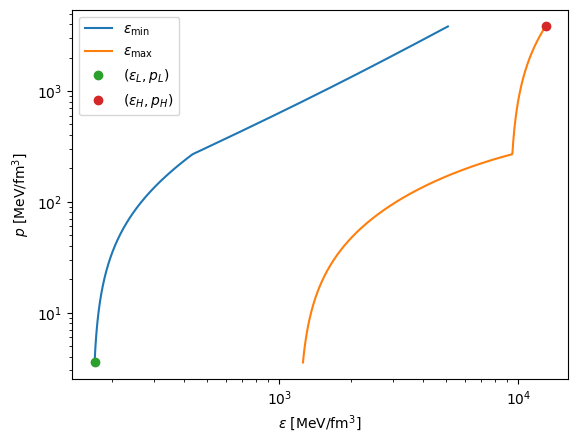

In [7]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(1000*constraints.epsilon_min(mu_array), 1000*constraints.pmax(mu_array, constraints.nmin(mu_array)), label=r'$\epsilon_\mathrm{min}$')
ax.plot(1000*constraints.epsilon_max(mu_array), 1000*constraints.pmin(mu_array), label=r'$\epsilon_\mathrm{max}$')

ax.plot(1000*epsilonL, 1000*pL, 'o', label=r'$(\epsilon_L, p_L)$')
ax.plot(1000*epsilonH, 1000*pH, 'o', label=r'$(\epsilon_H, p_H)$')

ax.set_xlabel(r'$\epsilon$ [MeV/fm$^3$]')
ax.set_ylabel(r'$p$ [MeV/fm$^3$]')

ax.legend()